In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [196]:
import sys
sys.path.extend(['.', '..'])

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.legend_handler import HandlerPatch
import matplotlib.gridspec as gridspec
plt.style.use('./paper.mplstyle')

from scipy import interpolate

from tqdm import tqdm_notebook as tqdm
import ternary

from utils import fr as fr_utils
from utils import misc as misc_utils
from utils.enums import MixingScenario

In [116]:
s = [1, 0, 0]
m = fr_utils.u_to_fr(s, np.array(fr_utils.NUFIT_U, dtype=np.complex128))
print s, r'-> [{0:6.3f} {1:6.3f} {2:6.3f}]'.format(*m), r'= [{0:6.3f} {1:6.3f}]'.format(*fr_utils.fr_to_angles(m))
s = [0, 1, 0]
m = fr_utils.u_to_fr(s, np.array(fr_utils.NUFIT_U, dtype=np.complex128))
print s, r'-> [{0:6.3f} {1:6.3f} {2:6.3f}]'.format(*m), r'= [{0:6.3f} {1:6.3f}]'.format(*fr_utils.fr_to_angles(m))
s = [1, 2, 0]
m = fr_utils.u_to_fr(s, np.array(fr_utils.NUFIT_U, dtype=np.complex128))
print s, r'-> [{0:6.3f} {1:6.3f} {2:6.3f}]'.format(*m), r'= [{0:6.3f} {1:6.3f}]'.format(*fr_utils.fr_to_angles(m))

[1, 0, 0] -> [ 0.550  0.183  0.267] = [ 0.537  0.269]
[0, 1, 0] -> [ 0.183  0.438  0.379] = [ 0.385 -0.158]
[1, 2, 0] -> [ 0.305  0.353  0.342] = [ 0.433 -0.031]


In [4]:
SM_120 = np.load('./chains/mcmc_unitary_DIM3_sfr_1_2_0_mfr_5.50076E+15_6.35502E+15_6.15862E+15_fix_scale_0.1_sigma_10000000_proc.npy')

T13_010 = np.genfromtxt('./frs/fr_DIM6_sfr_0_1_0_mfr_1_1_1_MixingScenario.T13_flat.txt')
T23_100 = np.genfromtxt('./frs/fr_DIM6_sfr_1_0_0_mfr_1_1_1_MixingScenario.T23_flat.txt')
#T13_010 = np.genfromtxt('./frs/fr_DIM4_sfr_0_1_0_mfr_1_1_1_MixingScenario.T13_flat.txt')
#T23_100 = np.genfromtxt('./frs/fr_DIM4_sfr_1_0_0_mfr_1_1_1_MixingScenario.T23_flat.txt')

In [5]:
print SM_120.shape, T13_010.shape, T23_100.shape

(200000, 3) (69648, 4) (69023, 4)


In [39]:
bc = np.genfromtxt('./bayes_contours.csv', delimiter=',', skip_header=2)

def swap(x):
    y = x.T
    return np.vstack([y[1], y[-1], y[0]]).T

def interp(i):
    x, y, z = i.T
    p = np.linspace(0, 1, len(x))
    q = np.linspace(0, 1, 100)
    s = 0.2
    x_ = interpolate.splev(q, interpolate.splrep(p, x, s=s))
    y_ = interpolate.splev(q, interpolate.splrep(p, y, s=s))
    z_ = interpolate.splev(q, interpolate.splrep(p, z, s=s))
    return np.vstack([x_, y_, z_]).T

contour_68_upper = np.array(interp(swap(bc[:,:3])))
contour_68_lower = np.array(interp(swap(bc[:,3:6])))
contour_90_upper = np.array(interp(swap(bc[:,6:9])))
contour_90_lower = np.array(interp(swap(bc[:,9:])))

In [42]:
T13_010_an = np.array(map(fr_utils.fr_to_angles, T13_010[:,:-1]))
T23_100_an = np.array(map(fr_utils.fr_to_angles, T23_100[:,:-1]))

contour_68_upper_an = np.array(map(fr_utils.fr_to_angles, contour_68_upper))
contour_68_lower_an = np.array(map(fr_utils.fr_to_angles, contour_68_lower))
contour_90_upper_an = np.array(map(fr_utils.fr_to_angles, contour_90_upper))
contour_90_lower_an = np.array(map(fr_utils.fr_to_angles, contour_90_lower))

In [9]:
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height,
                       fontsize, trans):
        r = 10
        x = r + width//2 + 10
        y = height//2 - 3

        # create 
        p = Circle(xy=(x, y), radius=r)

        # update with data from oryginal object
        self.update_prop(p, orig_handle, legend)

        # move xy to legend
        p.set_transform(trans)

        return [p]

In [10]:
def cmap_discretize(cmap, N):
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in xrange(N+1) ]
    # Return colormap object.
    return mpl.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

In [11]:
d = [T13_010, T23_100]
min_scale = 1E100
max_scale = -1E100

for i in d:
    min_scale = min_scale if min_scale < np.min(i[:,-1]) else np.min(i[:,-1])
    max_scale = max_scale if max_scale > np.max(i[:,-1]) else np.max(i[:,-1])

print 'min_scale', min_scale
print 'max_scale', max_scale

min_scale -52.0
max_scale -40.0


In [25]:
def alp(x):
    y = list(x)
    y[-1] = 0.7
    return y

#cmap_010 = plt.get_cmap('jet', 10)
#cmap_100 = plt.get_cmap('jet', 10)
cmap_g = mpl.colors.LinearSegmentedColormap.from_list("", ["lime", "gold", "darkorange"])
cmap_b = mpl.colors.LinearSegmentedColormap.from_list("", ["blue", "fuchsia", "darkmagenta"])
cmap_010 = cmap_discretize(cmap_g, 10)
cmap_100 = cmap_discretize(cmap_b, 10)

color_010 = map(alp, map(cmap_010, map(norm, T13_010[:,-1])))
color_100 = map(alp, map(cmap_100, map(norm, T23_100[:,-1])))

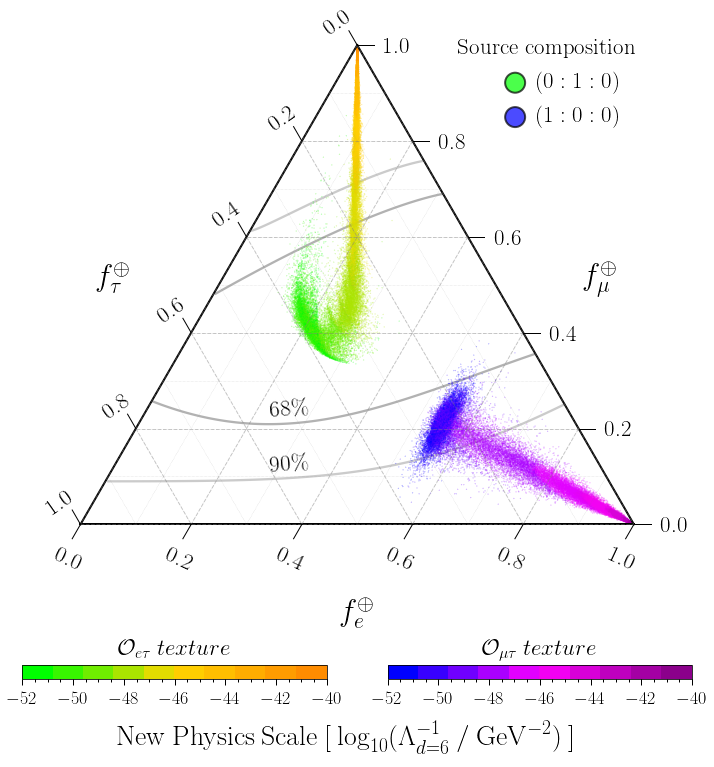

In [99]:
# Figure
fig = plt.figure(figsize=(12, 12))
#gs = gridspec.GridSpec(1, 2, width_ratios=[40, 1])
gs = gridspec.GridSpec(2, 1, height_ratios=[40, 1])
gs.update(hspace=0.3, wspace=0.15)

ax = fig.add_subplot(gs[0])
ax.set_aspect('equal')

norm = mpl.colors.Normalize(vmin=min_scale, vmax=max_scale)

# Boundary and Gridlines
scale = 1
fig, tax = ternary.figure(ax=ax, scale=scale)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color='grey', multiple=scale/5., linewidth=1.0, alpha=0.4, ls='--')
tax.gridlines(color='grey', multiple=scale/10., linewidth=0.5, alpha=0.4, ls=':')

# Set Axis labels and Title
fontsize = 23
tax.left_axis_label(r"$f_{\tau}^{\oplus}$", fontsize=fontsize+8, offset=0.2, rotation=0)
tax.right_axis_label(r"$f_{\mu}^{\oplus}$", fontsize=fontsize+8, offset=0.2, rotation=0)
tax.bottom_axis_label(r"$f_{e}^{\oplus}$", fontsize=fontsize+8, position=(0.55, -0.20/2, 0.5), rotation=0)

# Remove default Matplotlib axis
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()

# Plot
#tax.scatter(SM_120, marker='o', s=0.03, alpha=0.3, color='red')
#tax.scatter([[0, 1, 0]], marker='*', s=500, alpha=1.0, color='green', zorder=100)
#tax.scatter([[1, 0, 0]], marker='*', s=500, alpha=1.0, color='blue', zorder=100)

# Contour
tax.plot(contour_68_upper, linewidth=2.3, color='grey', zorder=0, alpha=0.6)
tax.plot(contour_68_lower, linewidth=2.3, color='grey', zorder=0, alpha=0.6)
tax.plot(contour_90_upper, linewidth=2.3, color='darkgrey', zorder=0, alpha=0.6)
tax.plot(contour_90_lower, linewidth=2.3, color='darkgrey', zorder=0, alpha=0.6)

# Lines
marker_style = dict(
    linestyle=' ', color='darkorange', linewidth=1.2,
    markersize=14, zorder=0
)

# Trajectories
tax.scatter(T13_010[:,:-1], marker='o', s=0.03, color=color_010)
tax.scatter(T23_100[:,:-1], marker='o', s=0.03, color=color_100)

# Text
#ax.text(0.63, 0.46, r'$\mathcal{O}_{e\mu}$', fontsize=fontsize,
#       rotation=0, verticalalignment='center')
ax.text(0.34, 0.2, r'$68\%$', fontsize=fontsize, rotation=5)
ax.text(0.34, 0.1, r'$90\%$', fontsize=fontsize, rotation=5)

# Legend
l_size = fontsize
legend_elements = []
#legend_elements.append(
#    Circle((0., 0.), 0.1, facecolor='red', alpha=0.7, edgecolor='k',
#           linewidth=2., label=r'$\left (1:2:0\right )$')
#)
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='lime', alpha=0.7, edgecolor='k',
           linewidth=2., label=r'$\left (0:1:0\right )$')
)
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='blue', alpha=0.7, edgecolor='k',
           linewidth=2., label=r'$\left (1:0:0\right )$')
)
legend = plt.legend(handles=legend_elements, loc=(0.65, 0.8),
                    title='Source composition',
                    fontsize=l_size,
                    handler_map={Circle: HandlerCircle()})
plt.setp(legend.get_title(), fontsize=l_size)
legend.get_frame().set_linestyle('-')

# Colorbar
gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1])
ax0 = fig.add_subplot(gs00[0])
cb = mpl.colorbar.ColorbarBase(ax0, cmap=cmap_010, norm=norm, orientation='horizontal')
cb.ax.tick_params(labelsize=fontsize-5)
ax0.text(0.5, 2, r'$\mathcal{O}_{e\tau}\:texture$', fontsize=fontsize,
         rotation=0, verticalalignment='center', horizontalalignment='center')


ax1 = fig.add_subplot(gs00[1])
cb = mpl.colorbar.ColorbarBase(ax1, cmap=cmap_100, norm=norm, orientation='horizontal')
cb.ax.tick_params(labelsize=fontsize-5)
#cb.set_label(r'${\rm New\:Physics\:Scale}\:[\:{\rm log}_{10} (\Lambda^{-1}_{d=6}\:/\:{\rm GeV}^{-2})\: ]$',
#            fontsize=fontsize+5, labelpad=20, horizontalalignment='left')
ax1.text(0.5, 2, r'$\mathcal{O}_{\mu\tau}\:texture$', fontsize=fontsize,
         rotation=0, verticalalignment='center', horizontalalignment='center')

fig.text(0.5, 0.038, r'${\rm New\:Physics\:Scale}\:[\:{\rm log}_{10} (\Lambda^{-1}_{d=6}\:/\:{\rm GeV}^{-2})\: ]$',
         fontsize=fontsize+5, horizontalalignment='center')

# Set ticks
tax.ticks(axis='blr', multiple=scale/5., linewidth=1, offset=0.03,
          fontsize=fontsize, tick_formats='%.1f')

tax._redraw_labels()

# save
fig.savefig('./plots/fr_trajectory.png', bbox_inches='tight', dpi=150)
#fig.savefig('./plots/fr_trajectory.pdf', bbox_inches='tight', dpi=150)

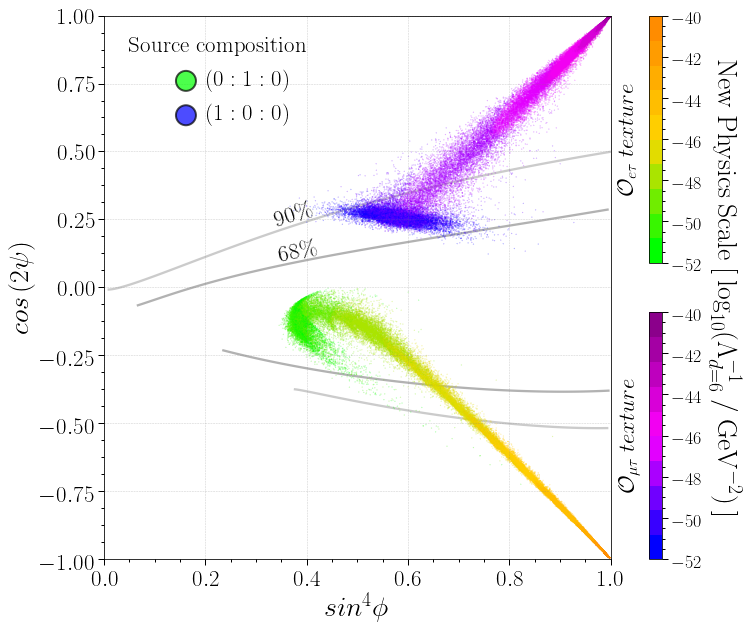

In [98]:
# Figure
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[40, 1])
gs.update(hspace=0.3, wspace=0.15)

ax = fig.add_subplot(gs[0])

ax.set_xlim(0, 1)
ax.set_ylim(-1, 1)

ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)

ax.set_xlabel(r'$sin^4\phi$', fontsize=fontsize+5)
ax.set_ylabel(r'$cos\left (2\psi\right )$', fontsize=fontsize+5)

for ymaj in ax.yaxis.get_majorticklocs():
    ax.axhline(y=ymaj, ls='--', color='gray', alpha=0.4, linewidth=0.5)
for xmaj in ax.xaxis.get_majorticklocs():
    ax.axvline(x=xmaj, ls='--', color='gray', alpha=0.4, linewidth=0.5)

# HESE data
ax.plot(contour_68_upper_an[:,0], contour_68_upper_an[:,1], linewidth=2.3, color='grey', zorder=0, alpha=0.6)
ax.plot(contour_68_lower_an[:,0], contour_68_lower_an[:,1], linewidth=2.3, color='grey', zorder=0, alpha=0.6)
ax.plot(contour_90_upper_an[:,0], contour_90_upper_an[:,1], linewidth=2.3, color='darkgrey', zorder=0, alpha=0.6)
ax.plot(contour_90_lower_an[:,0], contour_90_lower_an[:,1], linewidth=2.3, color='darkgrey', zorder=0, alpha=0.6)

# Plot
ax.scatter(T13_010_an[:,0], T13_010_an[:,1], marker='o', s=0.03, color=color_010)
ax.scatter(T23_100_an[:,0], T23_100_an[:,1], marker='o', s=0.03, color=color_100)

# Legend
l_size = fontsize
legend_elements = []
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='lime', alpha=0.7, edgecolor='k',
           linewidth=2., label=r'$\left (0:1:0\right )$')
)
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='blue', alpha=0.7, edgecolor='k',
           linewidth=2., label=r'$\left (1:0:0\right )$')
)
legend = plt.legend(handles=legend_elements, loc=(0.03, 0.78),
                    title='Source composition',
                    fontsize=l_size,
                    handler_map={Circle: HandlerCircle()})
plt.setp(legend.get_title(), fontsize=l_size)
legend.get_frame().set_linestyle('-')

# Colorbar
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1])
ax0 = fig.add_subplot(gs00[0])
cb = mpl.colorbar.ColorbarBase(ax0, cmap=cmap_010, norm=norm)
cb.ax.tick_params(labelsize=fontsize-5)
ax0.text(-1.5, 0.5, r'$\mathcal{O}_{e\tau}\:texture$', fontsize=fontsize,
         rotation=90, verticalalignment='center', horizontalalignment='center')


ax1 = fig.add_subplot(gs00[1])
cb = mpl.colorbar.ColorbarBase(ax1, cmap=cmap_100, norm=norm)
cb.ax.tick_params(labelsize=fontsize-5)
ax1.text(-1.5, 0.5, r'$\mathcal{O}_{\mu\tau}\:texture$', fontsize=fontsize,
         rotation=90, verticalalignment='center', horizontalalignment='center')

fig.text(0.98, 0.5, r'${\rm New\:Physics\:Scale}\:[\:{\rm log}_{10} (\Lambda^{-1}_{d=6}\:/\:{\rm GeV}^{-2})\: ]$',
         fontsize=fontsize+5, horizontalalignment='center', verticalalignment='center', rotation=-90)

# Text
ax.text(0.34, 0.12, r'$68\%$', fontsize=fontsize, rotation=12)
ax.text(0.33, 0.26, r'$90\%$', fontsize=fontsize, rotation=18)

fig.savefig('./plots/fr_an_trajectory.png', bbox_inches='tight', dpi=150)

In [143]:
sc = np.linspace(-52, -40, 1000)
energy = 1e6
    
s = [0, 1, 0]
frs_010 = []
for x in sc:
    u = fr_utils.params_to_BSMu(x, fix_mixing=MixingScenario.T13, dim=6, energy=energy)
    frs_010.append(fr_utils.u_to_fr(s, np.array(u, dtype=np.complex128)))
frs_010 = np.vstack(frs_010)

s = [1, 0, 0]
frs_100 = []
for x in sc:
    u = fr_utils.params_to_BSMu(x, fix_mixing=MixingScenario.T23, dim=6, energy=energy)
    frs_100.append(fr_utils.u_to_fr(s, np.array(u, dtype=np.complex128)))
frs_100 = np.vstack(frs_100)

In [144]:
frs_010_an = np.array(map(fr_utils.fr_to_angles, frs_010))
frs_100_an = np.array(map(fr_utils.fr_to_angles, frs_100))

color_fe_010 = map(alp, map(cmap_010, map(norm, sc)))
color_fe_100 = map(alp, map(cmap_100, map(norm, sc)))

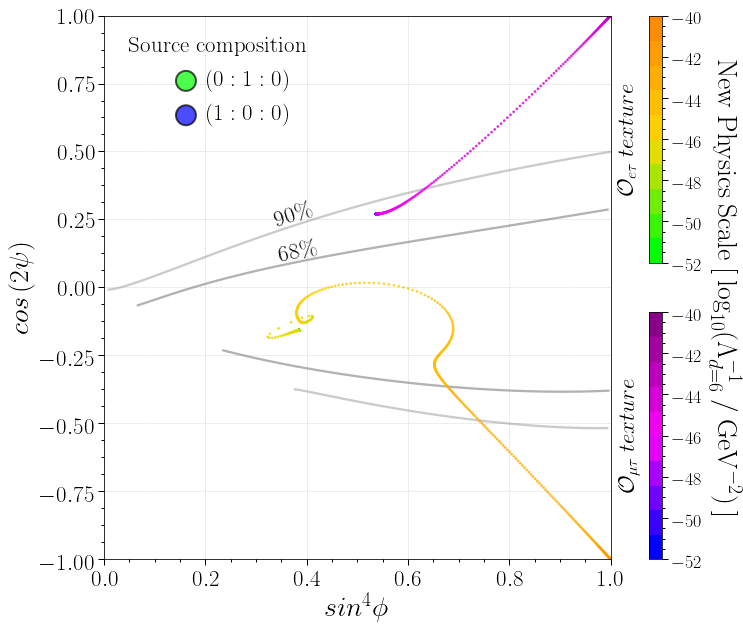

In [148]:
# Figure
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[40, 1])
gs.update(hspace=0.3, wspace=0.15)

ax = fig.add_subplot(gs[0])

ax.set_xlim(0, 1)
ax.set_ylim(-1, 1)

ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)

ax.set_xlabel(r'$sin^4\phi$', fontsize=fontsize+5)
ax.set_ylabel(r'$cos\left (2\psi\right )$', fontsize=fontsize+5)

for ymaj in ax.yaxis.get_majorticklocs():
    ax.axhline(y=ymaj, ls='--', color='gray', alpha=0.4, linewidth=0.5)
for xmaj in ax.xaxis.get_majorticklocs():
    ax.axvline(x=xmaj, ls='--', color='gray', alpha=0.4, linewidth=0.5)

# HESE data
ax.plot(contour_68_upper_an[:,0], contour_68_upper_an[:,1], linewidth=2.3, color='grey', zorder=0, alpha=0.6)
ax.plot(contour_68_lower_an[:,0], contour_68_lower_an[:,1], linewidth=2.3, color='grey', zorder=0, alpha=0.6)
ax.plot(contour_90_upper_an[:,0], contour_90_upper_an[:,1], linewidth=2.3, color='darkgrey', zorder=0, alpha=0.6)
ax.plot(contour_90_lower_an[:,0], contour_90_lower_an[:,1], linewidth=2.3, color='darkgrey', zorder=0, alpha=0.6)

# Plot
ax.scatter(frs_010_an[:,0], frs_010_an[:,1], marker='o', s=3, color=color_fe_010)
ax.scatter(frs_100_an[:,0], frs_100_an[:,1], marker='o', s=3, color=color_fe_100)

# Legend
l_size = fontsize
legend_elements = []
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='lime', alpha=0.7, edgecolor='k',
           linewidth=2., label=r'$\left (0:1:0\right )$')
)
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='blue', alpha=0.7, edgecolor='k',
           linewidth=2., label=r'$\left (1:0:0\right )$')
)
legend = plt.legend(handles=legend_elements, loc=(0.03, 0.78),
                    title='Source composition',
                    fontsize=l_size,
                    handler_map={Circle: HandlerCircle()})
plt.setp(legend.get_title(), fontsize=l_size)
legend.get_frame().set_linestyle('-')

# Colorbar
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1])
ax0 = fig.add_subplot(gs00[0])
cb = mpl.colorbar.ColorbarBase(ax0, cmap=cmap_010, norm=norm)
cb.ax.tick_params(labelsize=fontsize-5)
ax0.text(-1.5, 0.5, r'$\mathcal{O}_{e\tau}\:texture$', fontsize=fontsize,
         rotation=90, verticalalignment='center', horizontalalignment='center')


ax1 = fig.add_subplot(gs00[1])
cb = mpl.colorbar.ColorbarBase(ax1, cmap=cmap_100, norm=norm)
cb.ax.tick_params(labelsize=fontsize-5)
ax1.text(-1.5, 0.5, r'$\mathcal{O}_{\mu\tau}\:texture$', fontsize=fontsize,
         rotation=90, verticalalignment='center', horizontalalignment='center')

fig.text(0.98, 0.5, r'${\rm New\:Physics\:Scale}\:[\:{\rm log}_{10} (\Lambda^{-1}_{d=6}\:/\:{\rm GeV}^{-2})\: ]$',
         fontsize=fontsize+5, horizontalalignment='center', verticalalignment='center', rotation=-90)

# Text
ax.text(0.34, 0.12, r'$68\%$', fontsize=fontsize, rotation=12)
ax.text(0.33, 0.26, r'$90\%$', fontsize=fontsize, rotation=18)

fig.savefig('./plots/fr_an_fe_trajectory.png', bbox_inches='tight', dpi=150)

In [150]:
MCMC_100_sc = np.load('./chains/mcmc_chain_DIM6_sfr_1_0_0_mfr_1_1_1_MixingScenario.T23.npy')[:,-1]
MCMC_100_frs = np.load('./chains/mcmc_chain_DIM6_sfr_1_0_0_mfr_1_1_1_MixingScenario.T23_')
print MCMC_100.shape

(60000, 12)


In [250]:
color_MCMC_100 = map(alp, map(cmap_100, map(norm, MCMC_100_sc)))

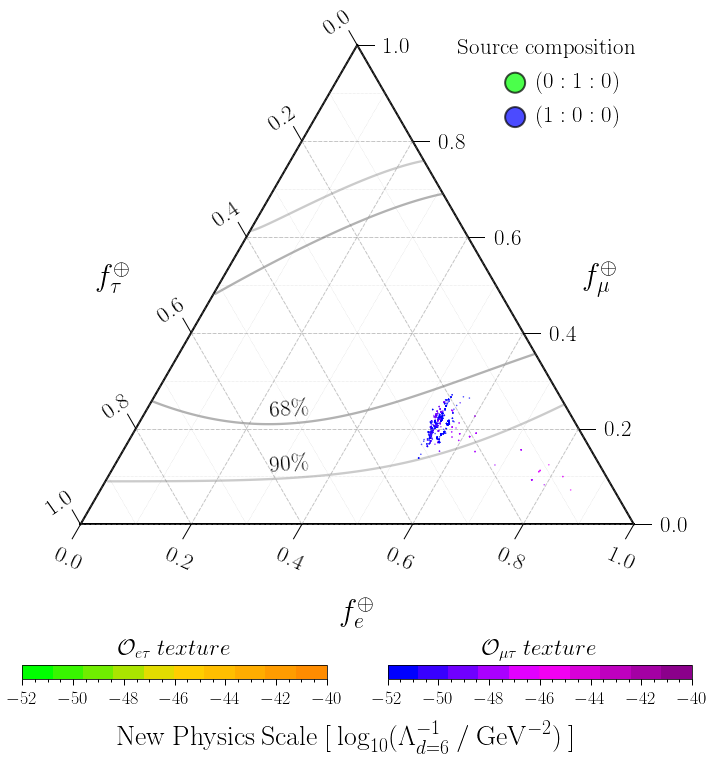

In [251]:
# Figure
fig = plt.figure(figsize=(12, 12))
#gs = gridspec.GridSpec(1, 2, width_ratios=[40, 1])
gs = gridspec.GridSpec(2, 1, height_ratios=[40, 1])
gs.update(hspace=0.3, wspace=0.15)

ax = fig.add_subplot(gs[0])
ax.set_aspect('equal')

norm = mpl.colors.Normalize(vmin=min_scale, vmax=max_scale)

# Boundary and Gridlines
scale = 1
fig, tax = ternary.figure(ax=ax, scale=scale)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color='grey', multiple=scale/5., linewidth=1.0, alpha=0.4, ls='--')
tax.gridlines(color='grey', multiple=scale/10., linewidth=0.5, alpha=0.4, ls=':')

# Set Axis labels and Title
fontsize = 23
tax.left_axis_label(r"$f_{\tau}^{\oplus}$", fontsize=fontsize+8, offset=0.2, rotation=0)
tax.right_axis_label(r"$f_{\mu}^{\oplus}$", fontsize=fontsize+8, offset=0.2, rotation=0)
tax.bottom_axis_label(r"$f_{e}^{\oplus}$", fontsize=fontsize+8, position=(0.55, -0.20/2, 0.5), rotation=0)

# Remove default Matplotlib axis
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()

# Plot
#tax.scatter(SM_120, marker='o', s=0.03, alpha=0.3, color='red')
#tax.scatter([[0, 1, 0]], marker='*', s=500, alpha=1.0, color='green', zorder=100)
#tax.scatter([[1, 0, 0]], marker='*', s=500, alpha=1.0, color='blue', zorder=100)

# Contour
tax.plot(contour_68_upper, linewidth=2.3, color='grey', zorder=0, alpha=0.6)
tax.plot(contour_68_lower, linewidth=2.3, color='grey', zorder=0, alpha=0.6)
tax.plot(contour_90_upper, linewidth=2.3, color='darkgrey', zorder=0, alpha=0.6)
tax.plot(contour_90_lower, linewidth=2.3, color='darkgrey', zorder=0, alpha=0.6)

# Lines
marker_style = dict(
    linestyle=' ', color='darkorange', linewidth=1.2,
    markersize=14, zorder=0
)

# Trajectories
#tax.scatter(T13_010[:,:-1], marker='o', s=0.03, color=color_010)
tax.scatter(MCMC_100_frs, marker='o', s=0.3, color=color_MCMC_100)

# Text
#ax.text(0.63, 0.46, r'$\mathcal{O}_{e\mu}$', fontsize=fontsize,
#       rotation=0, verticalalignment='center')
ax.text(0.34, 0.2, r'$68\%$', fontsize=fontsize, rotation=5)
ax.text(0.34, 0.1, r'$90\%$', fontsize=fontsize, rotation=5)

# Legend
l_size = fontsize
legend_elements = []
#legend_elements.append(
#    Circle((0., 0.), 0.1, facecolor='red', alpha=0.7, edgecolor='k',
#           linewidth=2., label=r'$\left (1:2:0\right )$')
#)
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='lime', alpha=0.7, edgecolor='k',
           linewidth=2., label=r'$\left (0:1:0\right )$')
)
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='blue', alpha=0.7, edgecolor='k',
           linewidth=2., label=r'$\left (1:0:0\right )$')
)
legend = plt.legend(handles=legend_elements, loc=(0.65, 0.8),
                    title='Source composition',
                    fontsize=l_size,
                    handler_map={Circle: HandlerCircle()})
plt.setp(legend.get_title(), fontsize=l_size)
legend.get_frame().set_linestyle('-')

# Colorbar
gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1])
ax0 = fig.add_subplot(gs00[0])
cb = mpl.colorbar.ColorbarBase(ax0, cmap=cmap_010, norm=norm, orientation='horizontal')
cb.ax.tick_params(labelsize=fontsize-5)
ax0.text(0.5, 2, r'$\mathcal{O}_{e\tau}\:texture$', fontsize=fontsize,
         rotation=0, verticalalignment='center', horizontalalignment='center')


ax1 = fig.add_subplot(gs00[1])
cb = mpl.colorbar.ColorbarBase(ax1, cmap=cmap_100, norm=norm, orientation='horizontal')
cb.ax.tick_params(labelsize=fontsize-5)
#cb.set_label(r'${\rm New\:Physics\:Scale}\:[\:{\rm log}_{10} (\Lambda^{-1}_{d=6}\:/\:{\rm GeV}^{-2})\: ]$',
#            fontsize=fontsize+5, labelpad=20, horizontalalignment='left')
ax1.text(0.5, 2, r'$\mathcal{O}_{\mu\tau}\:texture$', fontsize=fontsize,
         rotation=0, verticalalignment='center', horizontalalignment='center')

fig.text(0.5, 0.038, r'${\rm New\:Physics\:Scale}\:[\:{\rm log}_{10} (\Lambda^{-1}_{d=6}\:/\:{\rm GeV}^{-2})\: ]$',
         fontsize=fontsize+5, horizontalalignment='center')

# Set ticks
tax.ticks(axis='blr', multiple=scale/5., linewidth=1, offset=0.03,
          fontsize=fontsize, tick_formats='%.1f')

tax._redraw_labels()

# save
#fig.savefig('./plots/fr_trajectory.png', bbox_inches='tight', dpi=150)
#fig.savefig('./plots/fr_trajectory.pdf', bbox_inches='tight', dpi=150)